In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import celltypist
#import scvi
import scvelo as scv
from celltypist import models
import seaborn as sns

from matplotlib.pyplot import rc_context

sc.set_figure_params(dpi=100, color_map = 'viridis_r', transparent=False, frameon=False)
sc.settings.verbosity = 1
sc.logging.print_header()

version = '2023-05-16'

sc.settings.figdir = './scanpy/{}/graph'.format(version)
sc.settings.cachedir = './scanpy/{}/cache'.format(version)
%config InlineBackend.figure_format = 'retina'

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.0 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.7


# Import data (merge h5 and loom)

In [2]:
def merge_adata(loom_path, h5_path):
    ldata = scv.read(loom_path)
    adata_RNA = sc.read_10x_h5(h5_path)
    adata = scv.utils.merge(adata_RNA, ldata)
    adata.var_names_make_unique()
    print('Merge Finished')
    return adata

P1_after = merge_adata('./data/Huan_filtered_loom/P1_after.loom', './data/Huan_filtered_RNA/[P1_after] filtered_feature_bc_matrix.h5')
P1_crisis = merge_adata('./data/Huan_filtered_loom/P1_crisis.loom', './data/Huan_filtered_RNA/[P1_crisis] filtered_feature_bc_matrix.h5')
P2_after = merge_adata('./data/Huan_filtered_loom/P2_after.loom', './data/Huan_filtered_RNA/[P2_after] filtered_feature_bc_matrix.h5')
P2_crisis = merge_adata('./data/Huan_filtered_loom/P2_crisis.loom', './data/Huan_filtered_RNA/[P2_crisis] filtered_feature_bc_matrix.h5')

P1_after.obs['Phenotype']="After_crisis"
P1_after.obs['donor_id']="Patient_1"
P1_crisis.obs['Phenotype']="MG_crisis"
P1_crisis.obs['donor_id']="Patient_1"

P2_after.obs['Phenotype']="After_crisis"
P2_after.obs['donor_id']="Patient_2"
P2_crisis.obs['Phenotype']="MG_crisis"
P2_crisis.obs['donor_id']="Patient_2"


adata_MC = P1_crisis.concatenate(P1_after, P2_crisis, P2_after)
adata_MC

Merge Finished
Merge Finished
Merge Finished
Merge Finished


AnnData object with n_obs × n_vars = 38530 × 31915
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [3]:
adata_MC.obs

,initial_size_spliced,initial_size_unspliced,initial_size,Phenotype,donor_id,batch
AAACCTGAGAATGTGT-0,526,591,526.0,MG_crisis,Patient_1,0
AAACCTGAGCGATGAC-0,320,653,320.0,MG_crisis,Patient_1,0
AAACCTGAGCGCCTCA-0,257,624,257.0,MG_crisis,Patient_1,0
AAACCTGAGGCTAGCA-0,268,518,268.0,MG_crisis,Patient_1,0
AAACCTGAGGTAGCCA-0,193,393,193.0,MG_crisis,Patient_1,0
...,...,...,...,...,...,...
TTTGTCATCACGACTA-3,292,351,292.0,After_crisis,Patient_2,3
TTTGTCATCACTCTTA-3,105,124,105.0,After_crisis,Patient_2,3
TTTGTCATCGGGAGTA-3,284,613,284.0,After_crisis,Patient_2,3
TTTGTCATCTAACTCT-3,271,412,271.0,After_crisis,Patient_2,3


In [4]:
adata_MC.write('./write/MC_without_pp.h5ad')

... storing 'Phenotype' as categorical
... storing 'donor_id' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


# Pre-processing

In [3]:
adata_MC = sc.read('./write/MC_without_pp.h5ad')
adata_MC

AnnData object with n_obs × n_vars = 38530 × 31915
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
adata_MC.X.sum(axis = 1)

matrix([[ 7740.],
        [ 6633.],
        [ 6523.],
        ...,
        [ 7129.],
        [ 2822.],
        [11293.]], dtype=float32)

## Doublet removal

This step is processed on Google Colab (GPU support) with the aim of selecting doublet cells using the Scvi-tool.

Please refer to "Colab Scvi-tool.ipynb" to acquire "adata_MC_doublet.csv".

In [4]:
adata_MC_doublet = pd.read_csv('./write/adata_MC_doublet.csv', index_col=0)
adata_MC_doublet = adata_MC_doublet[~adata_MC_doublet['doublet']]
adata_MC_doublet

,doublet
AAACCTGAGAATGTGT-0,False
AAACCTGAGCGCCTCA-0,False
AAACCTGAGGCTAGCA-0,False
AAACCTGAGGTAGCCA-0,False
AAACCTGAGGTGGGTT-0,False
...,...
TTTGTCATCACGACTA-3,False
TTTGTCATCACTCTTA-3,False
TTTGTCATCGGGAGTA-3,False
TTTGTCATCTAACTCT-3,False


In [5]:
adata_MC = adata_MC[adata_MC.obs.index.isin(adata_MC_doublet.index)]
adata_MC

View of AnnData object with n_obs × n_vars = 34984 × 31915
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Romove low quality

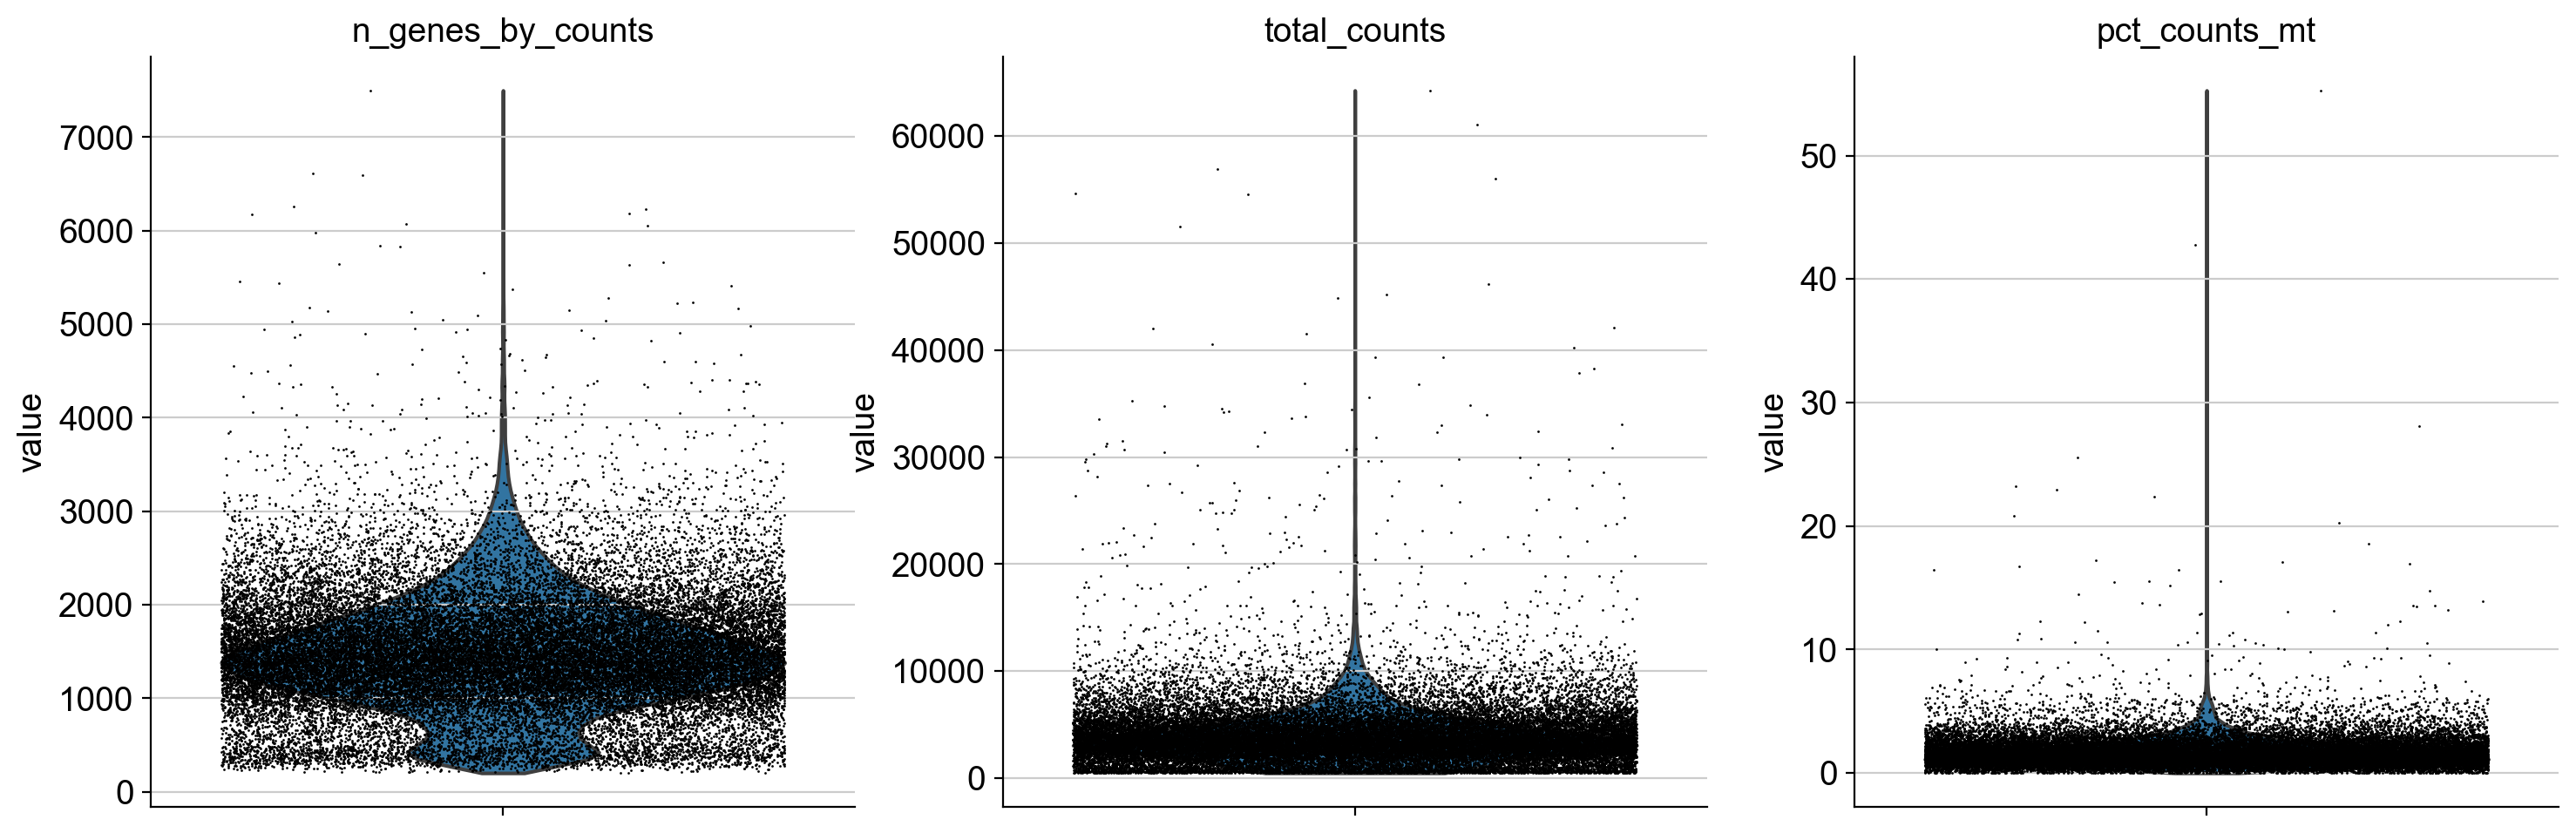

In [6]:
sc.pp.filter_cells(adata_MC, min_genes=200) #get rid of cells with fewer than 200 genes
sc.pp.filter_genes(adata_MC, min_cells=3) #get rid of genes that are found in fewer than 3 cells
adata_MC.var['mt'] = adata_MC.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_MC, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata_MC, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

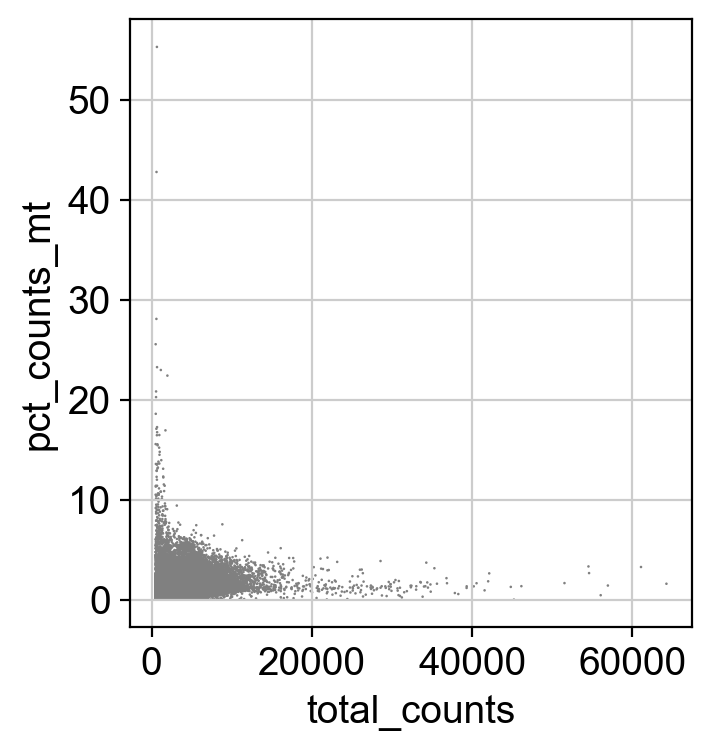

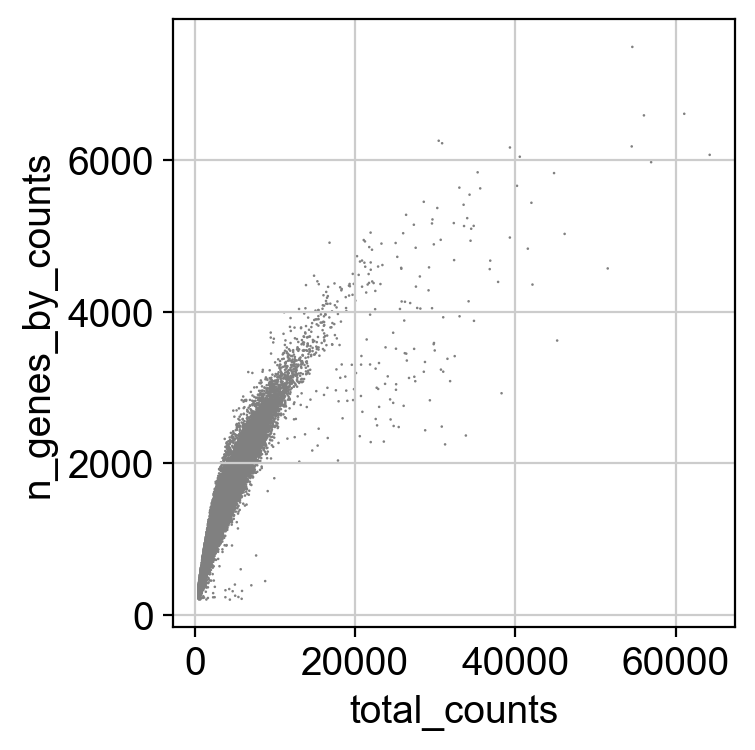

In [7]:
sc.pl.scatter(adata_MC, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_MC, x='total_counts', y='n_genes_by_counts')

In [8]:
upper_lim = np.quantile(adata_MC.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata_MC.obs.n_genes_by_counts.values, .02)
print(f"n_genes_by_counts: {lower_lim} - {upper_lim}")
adata_MC = adata_MC[(adata_MC.obs.n_genes_by_counts < upper_lim) & (adata_MC.obs.n_genes_by_counts > lower_lim)]
adata_MC = adata_MC[adata_MC.obs.pct_counts_mt < 20]
adata_MC.layers['counts'] = adata_MC.X.copy() # save raw counts

sc.pp.normalize_total(adata_MC, target_sum=1e4) #normalize every cell to 10,000 UMI
sc.pp.log1p(adata_MC) #change to log counts

n_genes_by_counts: 341.0 - 2934.0


<AxesSubplot: ylabel='Frequency'>

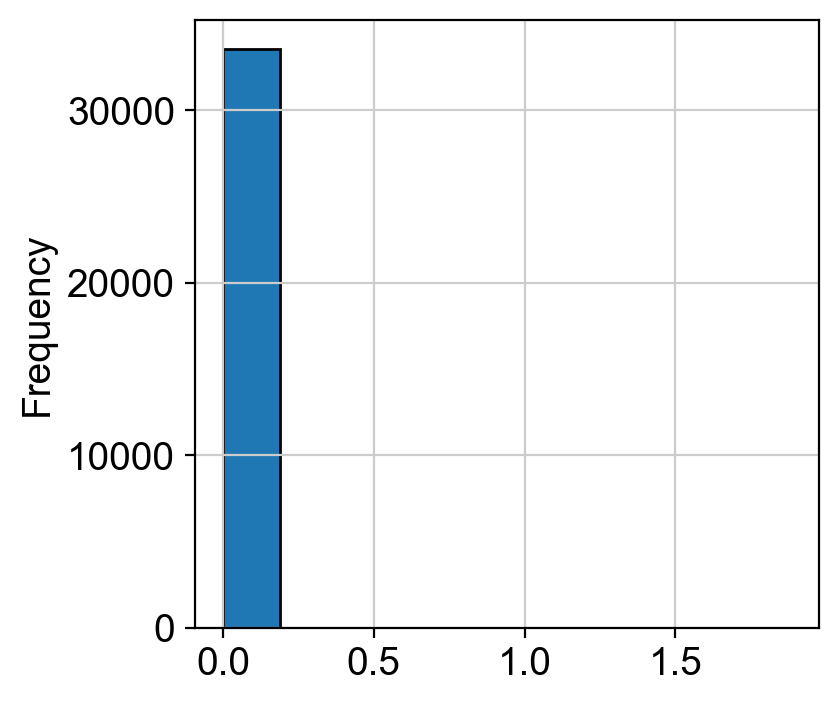

In [8]:
adata_MC[:,'IL6'].to_df()['IL6'].plot(kind='hist', edgecolor='black')

In [9]:
adata_MC

AnnData object with n_obs × n_vars = 33577 × 19590
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'

In [ ]:
adata_MC.X.sum(axis = 1)

matrix([[2722.9512],
        [2788.076 ],
        [2868.908 ],
        ...,
        [2479.0732],
        [2310.0388],
        [2888.9985]], dtype=float32)

## Highly-variable genes

In [10]:
#sc.pp.highly_variable_genes(adata_huan, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
#sc.pp.highly_variable_genes(adata_huan, n_top_genes=3000) 
adata_MC.raw = adata_MC #save raw data before processing values and further filtering
#adata_huan = adata_huan[:, adata_huan.var.highly_variable] #filter highly variable
sc.pp.regress_out(adata_MC, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.scale(adata_MC, max_value=10) #scale each gene to unit variance

In [11]:
adata_MC.write('./write/MC_without_harmony.h5ad')

# Integration

## Before integration (orignial)

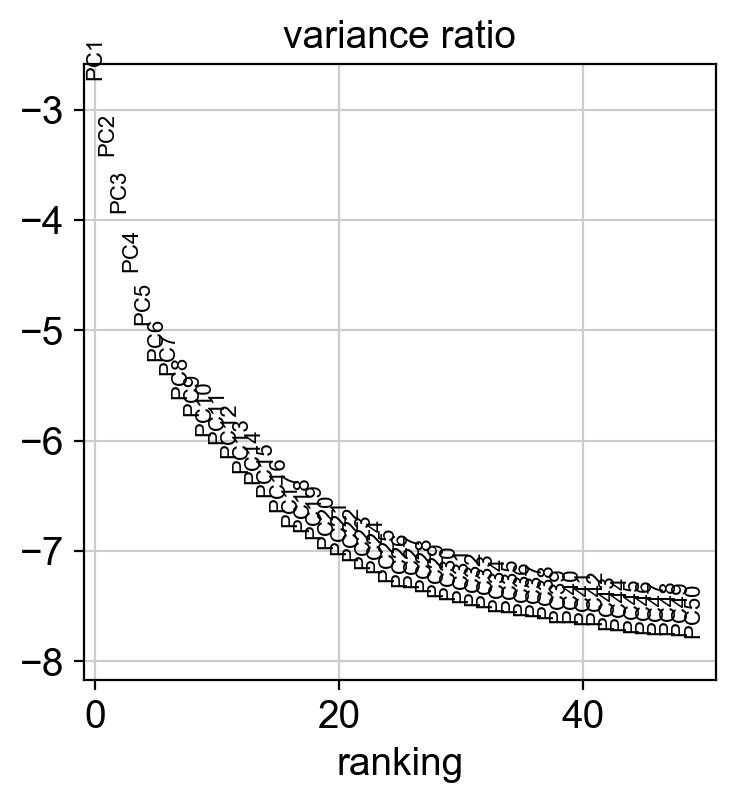

In [9]:
sc.tl.pca(adata_MC, svd_solver='auto')
sc.pl.pca_variance_ratio(adata_MC, log=True, n_pcs=50, save='')

In [11]:
sc.pp.neighbors(adata_MC, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata_MC)
adata_MC

AnnData object with n_obs × n_vars = 33577 × 19590
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'
    obsp: 'distances', 'connectivities'

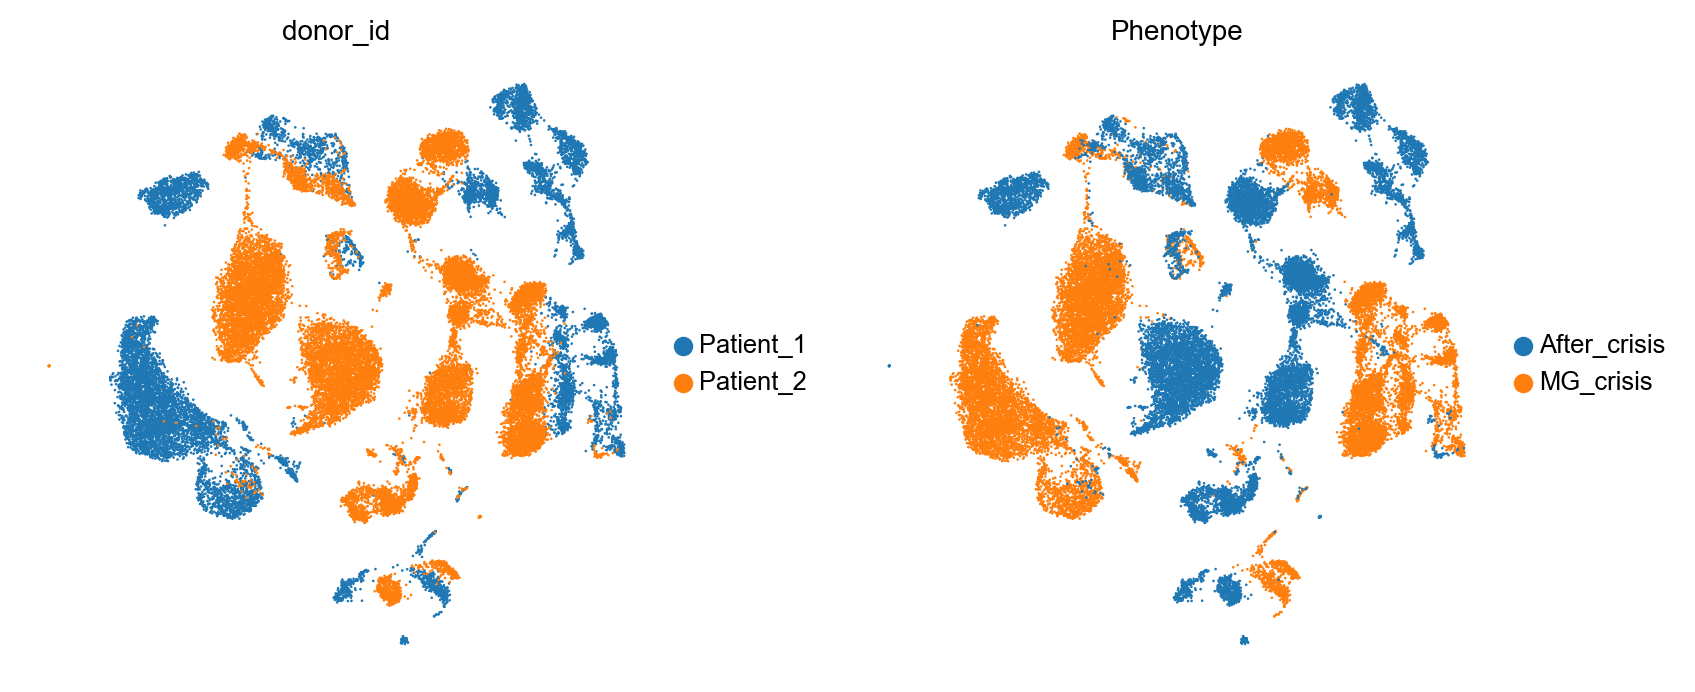

In [12]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r', fontsize=10, transparent=True, frameon=False)

sc.pl.umap(adata_MC, color = ['donor_id', 'Phenotype', ], save='before integration') #'majority_voting', 'predicted_labels_NC2022' ,legend_loc = 'on data', 

## After integration (harmony)

In [13]:
sc.external.pp.harmony_integrate(adata_MC, ['donor_id', 'Phenotype'], max_iter_harmony = 30, lamb = 2)
adata_MC.obsm['X_pca'] = adata_MC.obsm['X_pca_harmony']
sc.pp.neighbors(adata_MC, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata_MC)

2023-05-16 15:32:11,750 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2023-05-16 15:32:24,438 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2023-05-16 15:32:38,212 - harmonypy - INFO - Iteration 3 of 30
Iteration 3 of 30
2023-05-16 15:32:52,264 - harmonypy - INFO - Iteration 4 of 30
Iteration 4 of 30
2023-05-16 15:33:05,578 - harmonypy - INFO - Iteration 5 of 30
Iteration 5 of 30
2023-05-16 15:33:18,622 - harmonypy - INFO - Iteration 6 of 30
Iteration 6 of 30
2023-05-16 15:33:32,519 - harmonypy - INFO - Iteration 7 of 30
Iteration 7 of 30
2023-05-16 15:33:39,996 - harmonypy - INFO - Converged after 7 iterations
Converged after 7 iterations


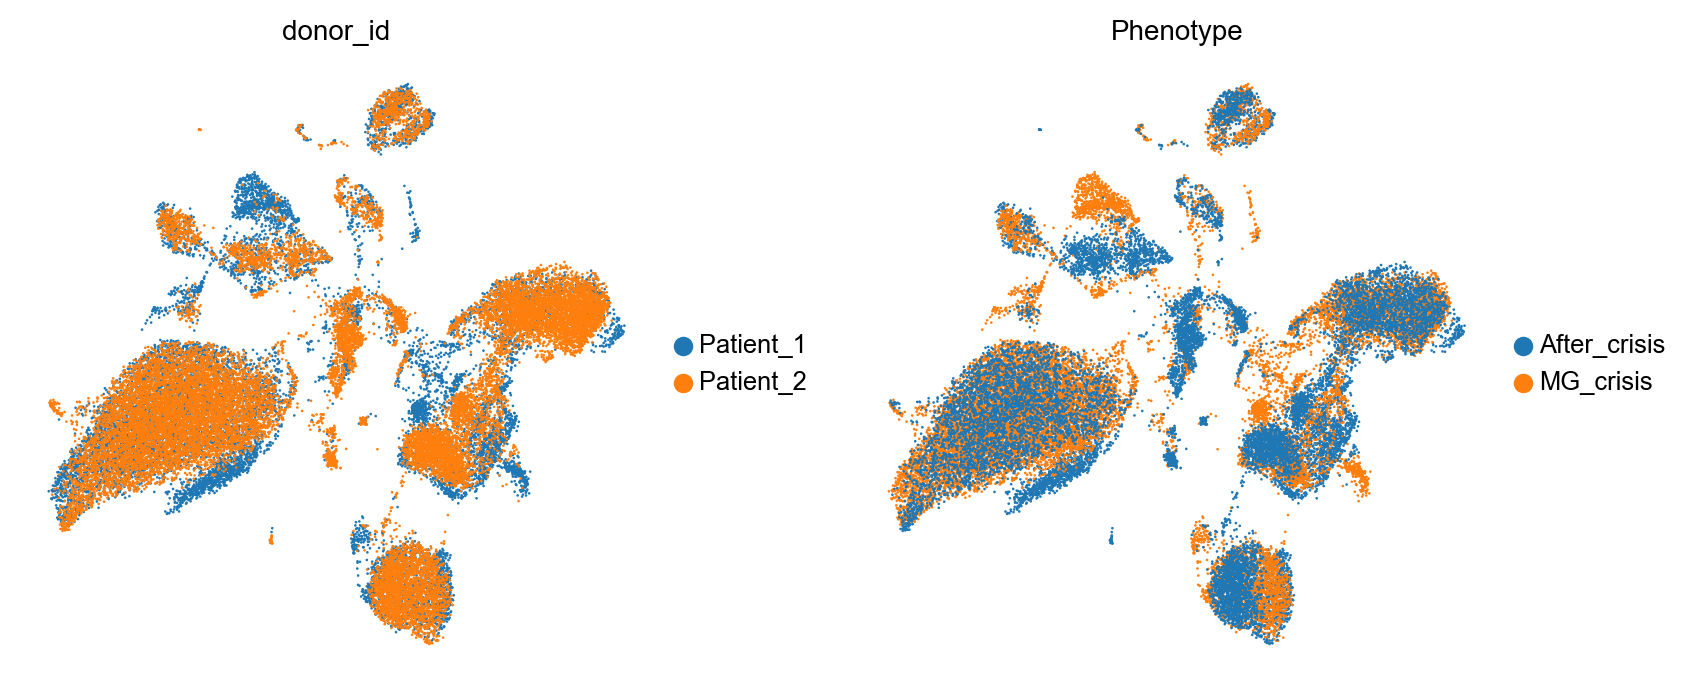

In [14]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r', fontsize=10, transparent=True, frameon=False)

sc.pl.umap(adata_MC, color = ['donor_id', 'Phenotype', ], save='after integration') #'majority_voting', 'predicted_labels_NC2022' ,legend_loc = 'on data', 

# Cell type interring

## Cell typist annotation （Transfered from NC2022）

Yasumizu, Y., Ohkura, N., Murata, H. et al. Myasthenia gravis-specific aberrant neuromuscular gene expression by medullary thymic epithelial cells in thymoma. Nat CommunIF 17.694Q1C1Top 13, 4230 (2022). https://doi.org/10.1038/s41467-022-31951-8

In [15]:
# CellTypist prediction 
import time
t_start = time.time()
predictions = celltypist.annotate(adata_MC, model = 'celltypist_NC2022_PBMC.pkl', majority_voting = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🔬 Input data has 33577 cells and 19590 genes
🔗 Matching reference genes in the model
🧬 2289 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


Time elapsed: 9.62671160697937 seconds


In [16]:
predictions.predicted_labels.rename(columns={"predicted_labels": "predicted_labels_NC2022", "majority_voting": "majority_voting_NC2022"}, inplace=True)
predictions.predicted_labels.drop('over_clustering', axis=1, inplace=True)
predictions.predicted_labels

,predicted_labels_NC2022,majority_voting_NC2022
AAACCTGAGAATGTGT-0,Monocyte (CD14),Monocyte (CD14)
AAACCTGAGCGCCTCA-0,Monocyte (CD16),Monocyte (CD14)
AAACCTGAGGCTAGCA-0,Monocyte (CD14),Monocyte (CD14)
AAACCTGAGGTAGCCA-0,NK cell,NK cell
AAACCTGAGGTGGGTT-0,Monocyte (CD14),Monocyte (CD14)
...,...,...
TTTGTCATCACGACTA-3,NK cell,NK cell
TTTGTCATCACTCTTA-3,NK cell,Monocyte (CD14)
TTTGTCATCGGGAGTA-3,Monocyte (CD14),Monocyte (CD14)
TTTGTCATCTAACTCT-3,Monocyte (CD14),Monocyte (CD14)


In [17]:
adata_MC.obs = pd.concat([adata_MC.obs,predictions.predicted_labels], axis=1)
adata_MC

AnnData object with n_obs × n_vars = 33577 × 19590
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels_NC2022', 'majority_voting_NC2022'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'donor_id_colors', 'Phenotype_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'
    obsp: 'distances', 'connectivities'

## Cell typist annotation （build-in）

In [18]:
# Load celltypist model 
model_low = models.Model.load(model = 'Immune_All_Low.pkl')
model_low.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

In [19]:
predictions_low = celltypist.annotate(adata_MC, model_low, majority_voting = True)

🔬 Input data has 33577 cells and 19590 genes
🔗 Matching reference genes in the model
🧬 5644 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


In [20]:
predictions_low.predicted_labels.rename(columns={"predicted_labels": "predicted_labels_builtin", "majority_voting": "majority_voting_builtin"}, inplace=True)
predictions_low.predicted_labels.drop('over_clustering', axis=1, inplace=True)
predictions_low.predicted_labels

,predicted_labels_builtin,majority_voting_builtin
AAACCTGAGAATGTGT-0,Classical monocytes,Classical monocytes
AAACCTGAGCGCCTCA-0,Classical monocytes,Classical monocytes
AAACCTGAGGCTAGCA-0,Classical monocytes,Classical monocytes
AAACCTGAGGTAGCCA-0,CD16+ NK cells,CD16+ NK cells
AAACCTGAGGTGGGTT-0,Classical monocytes,Classical monocytes
...,...,...
TTTGTCATCACGACTA-3,CD16+ NK cells,CD16+ NK cells
TTTGTCATCACTCTTA-3,Megakaryocytes/platelets,Megakaryocytes/platelets
TTTGTCATCGGGAGTA-3,Classical monocytes,Classical monocytes
TTTGTCATCTAACTCT-3,Classical monocytes,Classical monocytes


In [21]:
adata_MC.obs = pd.concat([adata_MC.obs,predictions_low.predicted_labels], axis=1)
adata_MC

AnnData object with n_obs × n_vars = 33577 × 19590
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Phenotype', 'donor_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'predicted_labels_NC2022', 'majority_voting_NC2022', 'predicted_labels_builtin', 'majority_voting_builtin'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'donor_id_colors', 'Phenotype_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'
    obsp: 'distances', 'connectivities'

# Leiden Clustering

In [31]:
sc.tl.leiden(adata_MC, key_added = "leiden", resolution=0.5) 

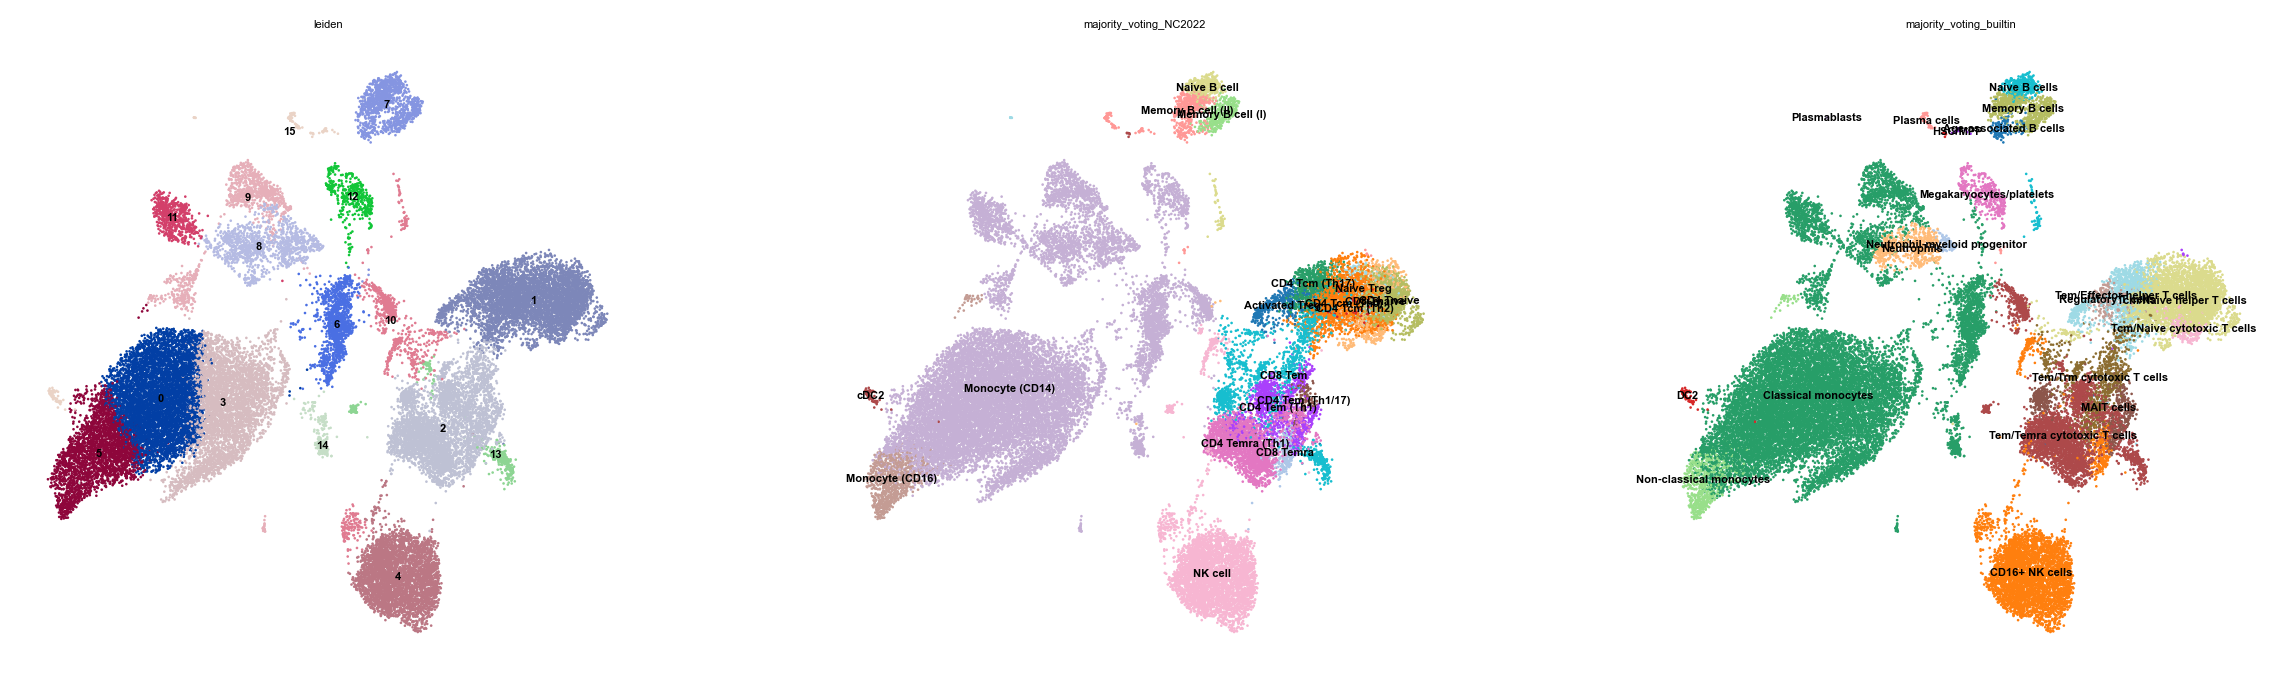

In [32]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r', fontsize=4, transparent=True, frameon=False)

sc.pl.umap(adata_MC, color=['leiden', 'majority_voting_NC2022', 'majority_voting_builtin'], legend_loc = 'on data', save='umap_leiden') 

In [24]:
adata_MC.write('./write/MC_leiden.h5ad')

# Course annotation

In [27]:
adata_MC = sc.read('./write/MC_leiden.h5ad')
adata_MC.uns['log1p']["base"] = None

In [28]:
sc.tl.rank_genes_groups(adata_MC, 'leiden')

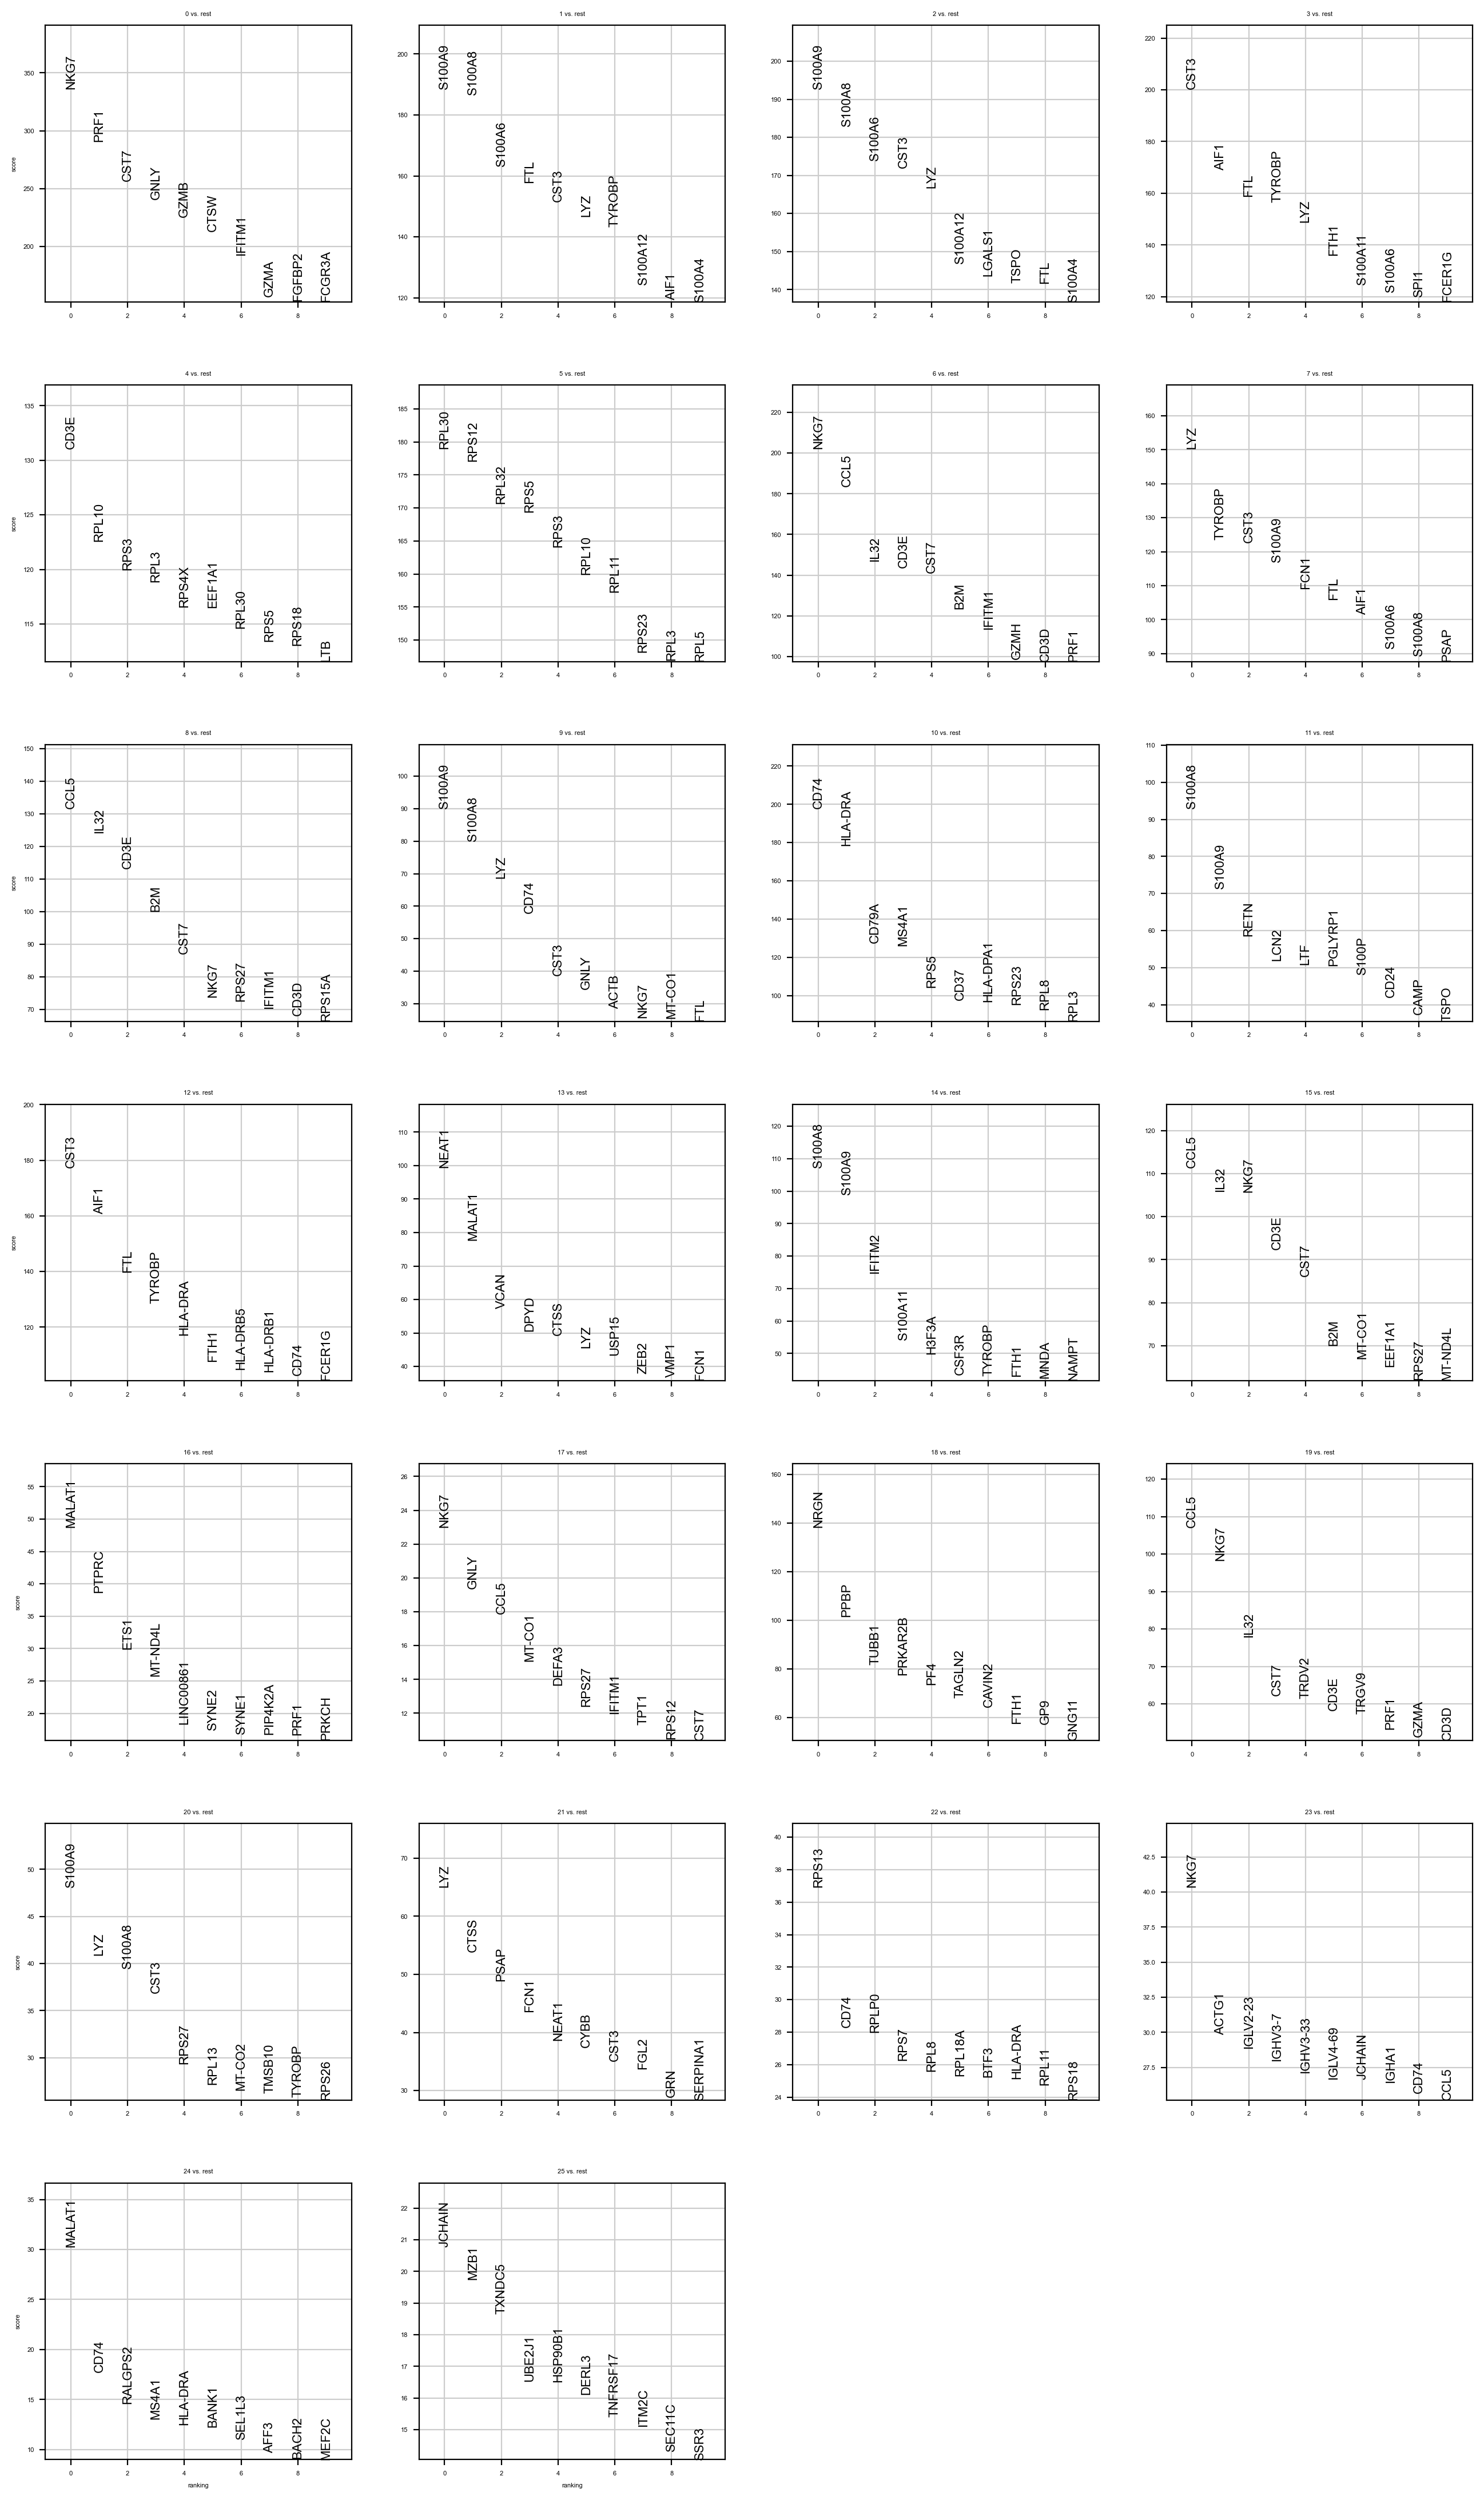

In [29]:
sc.pl.rank_genes_groups(adata_MC, n_genes=10, sharey=False, save='adata_MC_leiden rank_genes_groups n_genes=10')

In [30]:
pd.DataFrame(adata_MC.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,NKG7,S100A9,S100A9,CST3,CD3E,RPL30,NKG7,LYZ,CCL5,S100A9,...,MALAT1,NKG7,NRGN,CCL5,S100A9,LYZ,RPS13,NKG7,MALAT1,JCHAIN
1,PRF1,S100A8,S100A8,AIF1,RPL10,RPS12,CCL5,TYROBP,IL32,S100A8,...,PTPRC,GNLY,PPBP,NKG7,LYZ,CTSS,CD74,ACTG1,CD74,MZB1
2,CST7,S100A6,S100A6,FTL,RPS3,RPL32,IL32,CST3,CD3E,LYZ,...,ETS1,CCL5,TUBB1,IL32,S100A8,PSAP,RPLP0,IGLV2-23,RALGPS2,TXNDC5
3,GNLY,FTL,CST3,TYROBP,RPL3,RPS5,CD3E,S100A9,B2M,CD74,...,MT-ND4L,MT-CO1,PRKAR2B,CST7,CST3,FCN1,RPS7,IGHV3-7,MS4A1,UBE2J1
4,GZMB,CST3,LYZ,LYZ,RPS4X,RPS3,CST7,FCN1,CST7,CST3,...,LINC00861,DEFA3,PF4,TRDV2,RPS27,NEAT1,RPL8,IGHV3-33,HLA-DRA,HSP90B1


In [ ]:
marker_genes = ['CD79A', 'MS4A1', 'CD19', # B cell
                'IL7R', 'CD8A', # CD4 T AND CD8 T cell
                'S100A9', 'LYZ', 'FCN1', # Monocytes
                'C1QA', 'CD68', 'TREM2', # Macrophage
                'CD1C', 'FCER1A', 'CLEC10A', # Dendrictic cell
                'GNLY', 'XCL2', 'NKG7', # NK cells
                'CMTM5', 'ITGA2B', 'PF4', #Megakaryocytes
                'CLDN5', 'PLVAP','SPARCL1', # Endothelial cell
                'HBM', 'HBQ1', 'GYPA',] # Erythrocyte   

In [58]:
mapping = {
        'Classical monocytes': 'Monocytes',
        'CD16+ NK cells': 'NK cells',
        'MAIT cells': 'T cells',
        'Megakaryocytes/platelets': 'Megakaryocytes',
        'Tem/Temra cytotoxic T cells': 'T cells',
        'Tcm/Naive helper T cells': 'T cells',
        'Non-classical monocytes': 'Monocytes',
        'Tem/Effector helper T cells': 'T cells',
        'Regulatory T cells': 'T cells',
        'Naive B cells': 'B cells',
        'Tem/Trm cytotoxic T cells': 'T cells',
        'Plasma cells': 'B cells',
        'Memory B cells': 'B cells',
        'Age-associated B cells': 'B cells',
        'Neutrophils': 'Neutrophils',
        'Tcm/Naive cytotoxic T cells': 'T cells',
        'DC2': 'DC2',
        'Neutrophil-myeloid progenitor': 'Neutrophil-myeloid progenitor',
        'HSC/MPP': 'HSC/MPP',
        'Plasmablasts': 'B cells'
    }
    
adata_MC.obs['Major_cluster'] = adata_MC.obs['majority_voting_builtin'].map(mapping)

... storing 'Major_cluster' as categorical
... storing 'Sample' as categorical


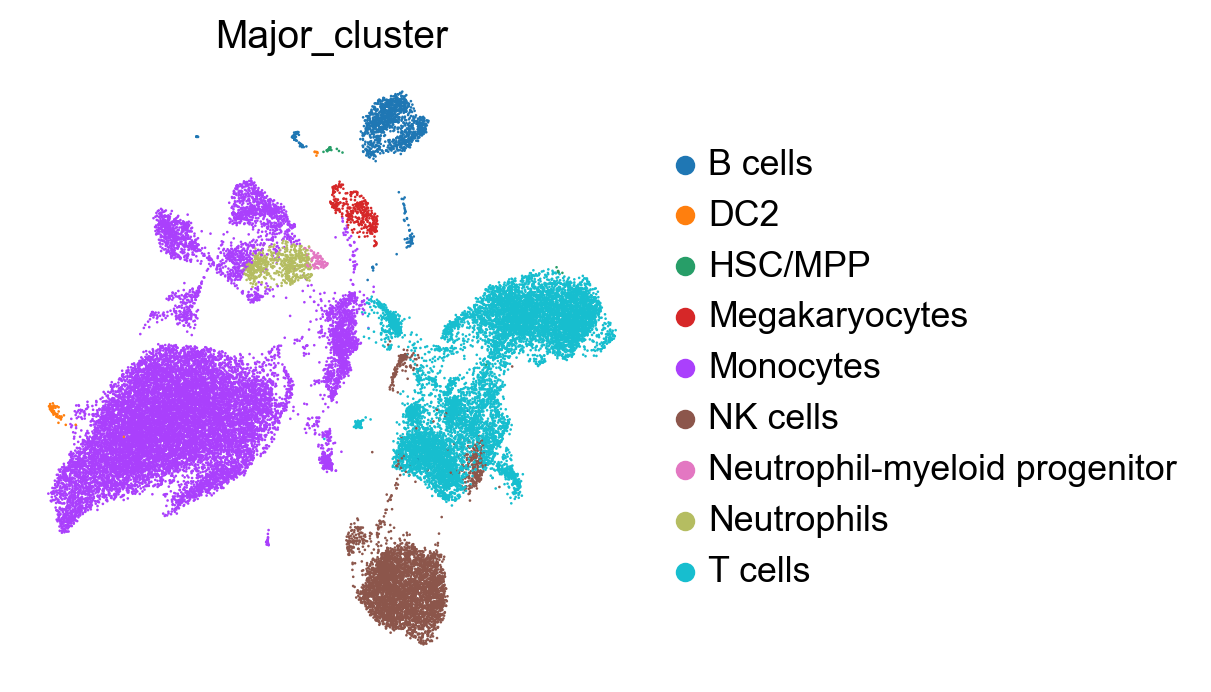

In [59]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r', transparent=False, frameon=False)

sc.pl.umap(adata_MC, color = ['Major_cluster'], save='MC_Major_cluster')

In [46]:
adata_MC.obs["Sample"] = adata_MC.obs["donor_id"].astype(str) +'_' +adata_MC.obs["Phenotype"].astype(str)
adata_MC.obs

,initial_size_spliced,initial_size_unspliced,initial_size,Phenotype,donor_id,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,predicted_labels_NC2022,majority_voting_NC2022,predicted_labels_builtin,majority_voting_builtin,leiden,Major_cluster,Sample
AAACCTGAGAATGTGT-0,526,591,526.0,MG_crisis,Patient_1,0,2267,2266,7739.0,58.0,0.749451,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,0,Monocytes,Patient_1_MG_crisis
AAACCTGAGCGCCTCA-0,257,624,257.0,MG_crisis,Patient_1,0,2102,2102,6523.0,58.0,0.889161,Monocyte (CD16),Monocyte (CD14),Classical monocytes,Classical monocytes,5,Monocytes,Patient_1_MG_crisis
AAACCTGAGGCTAGCA-0,268,518,268.0,MG_crisis,Patient_1,0,1953,1953,4736.0,43.0,0.907939,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,0,Monocytes,Patient_1_MG_crisis
AAACCTGAGGTAGCCA-0,193,393,193.0,MG_crisis,Patient_1,0,1557,1557,2929.0,80.0,2.731308,NK cell,NK cell,CD16+ NK cells,CD16+ NK cells,4,NK cells,Patient_1_MG_crisis
AAACCTGAGGTGGGTT-0,488,865,488.0,MG_crisis,Patient_1,0,2766,2766,9678.0,103.0,1.064269,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,5,Monocytes,Patient_1_MG_crisis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCACGACTA-3,292,351,292.0,After_crisis,Patient_2,3,1466,1466,3059.0,31.0,1.013403,NK cell,NK cell,CD16+ NK cells,CD16+ NK cells,4,NK cells,Patient_2_After_crisis
TTTGTCATCACTCTTA-3,105,124,105.0,After_crisis,Patient_2,3,514,514,1023.0,14.0,1.368524,NK cell,Monocyte (CD14),Megakaryocytes/platelets,Megakaryocytes/platelets,12,Megakaryocytes,Patient_2_After_crisis
TTTGTCATCGGGAGTA-3,284,613,284.0,After_crisis,Patient_2,3,1971,1971,7129.0,61.0,0.855660,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,0,Monocytes,Patient_2_After_crisis
TTTGTCATCTAACTCT-3,271,412,271.0,After_crisis,Patient_2,3,1273,1273,2822.0,63.0,2.232459,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,3,Monocytes,Patient_2_After_crisis


In [60]:
adata_MC.obs

,initial_size_spliced,initial_size_unspliced,initial_size,Phenotype,donor_id,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,predicted_labels_NC2022,majority_voting_NC2022,predicted_labels_builtin,majority_voting_builtin,leiden,Major_cluster,Sample
AAACCTGAGAATGTGT-0,526,591,526.0,MG_crisis,Patient_1,0,2267,2266,7739.0,58.0,0.749451,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,0,Monocytes,Patient_1_MG_crisis
AAACCTGAGCGCCTCA-0,257,624,257.0,MG_crisis,Patient_1,0,2102,2102,6523.0,58.0,0.889161,Monocyte (CD16),Monocyte (CD14),Classical monocytes,Classical monocytes,5,Monocytes,Patient_1_MG_crisis
AAACCTGAGGCTAGCA-0,268,518,268.0,MG_crisis,Patient_1,0,1953,1953,4736.0,43.0,0.907939,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,0,Monocytes,Patient_1_MG_crisis
AAACCTGAGGTAGCCA-0,193,393,193.0,MG_crisis,Patient_1,0,1557,1557,2929.0,80.0,2.731308,NK cell,NK cell,CD16+ NK cells,CD16+ NK cells,4,NK cells,Patient_1_MG_crisis
AAACCTGAGGTGGGTT-0,488,865,488.0,MG_crisis,Patient_1,0,2766,2766,9678.0,103.0,1.064269,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,5,Monocytes,Patient_1_MG_crisis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCACGACTA-3,292,351,292.0,After_crisis,Patient_2,3,1466,1466,3059.0,31.0,1.013403,NK cell,NK cell,CD16+ NK cells,CD16+ NK cells,4,NK cells,Patient_2_After_crisis
TTTGTCATCACTCTTA-3,105,124,105.0,After_crisis,Patient_2,3,514,514,1023.0,14.0,1.368524,NK cell,Monocyte (CD14),Megakaryocytes/platelets,Megakaryocytes/platelets,12,Megakaryocytes,Patient_2_After_crisis
TTTGTCATCGGGAGTA-3,284,613,284.0,After_crisis,Patient_2,3,1971,1971,7129.0,61.0,0.855660,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,0,Monocytes,Patient_2_After_crisis
TTTGTCATCTAACTCT-3,271,412,271.0,After_crisis,Patient_2,3,1273,1273,2822.0,63.0,2.232459,Monocyte (CD14),Monocyte (CD14),Classical monocytes,Classical monocytes,3,Monocytes,Patient_2_After_crisis


In [43]:
adata_MC.write('./write/MC_leiden.h5ad')